# Исследование данных о пользователях приложения Procrastinate Pro+

В нашем распоряжении данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года развлекательного приложения Procrastinate Pro+. Нам необходимо разобраться в причинах, по которым компания терпит убытки несмотря на огромные вложения в рекламу и помочь компании выйти в плюс.

**Цель исследования:**
1. Откуда приходят пользователи и какими устройствами они пользуются
2. Сколько стоит привлечение пользователей из различных рекламных каналов
3. Сколько денег приносит каждый клиент
4. Когда расходы на привлечение клиента окупаются
5. Какие факторы мешают привлечению клиентов

**Ход исследования**

Данные о пользователях мы получим из трех источников 
- визиты: `/datasets/visits_info_short.csv`.
- заказы: `/datasets/orders_info_short.csv`.
- расходы: `/datasets/costs_info_short.csv`.

Первым делом приступим к обзору данных, проверим качество. Далее при необходимости осуществим предобработку данных для дальнейшего корректного анализа и приступим к исследованию данных.

Исходя из этого наш проект будет состоять из шести частей:
- Загрузка и подготовка данных к исследованию
- Написание функций для анализа
- Исследовательский анализ: распределение пользователей по странам, устройствам, каналам
- Исследование затрат на маркетинг: расходы в целом, динамика расходов, средняя стоимость привлечения клиента
- Оценка окупаемости рекламы: с разбивкой по странам, устройствам и каналам
- Общие выводы

## Изучение и предобработка данных

In [1]:
# импортируем библиотеки, которые будем использовать в работе
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# загрузим данные
visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'), # журнал визитов
    pd.read_csv('orders_info_short.csv'), # заказы
    pd.read_csv('costs_info_short.csv')   # расходы
)

### Таблица visits

In [3]:
display(visits.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Структура таблицы visits:
* User Id — уникальный идентификатор пользователя,
* Region — страна пользователя,
* Device — тип устройства пользователя,
* Channel — идентификатор источника перехода,
* Session Start — дата и время начала сессии,
* Session End — дата и время окончания сессии.

In [4]:
# выводим общую информацию, информацию о пропусках и явных дубликатах по данным таблицы visits
temp_visits = visits.copy() 
list_c = visits.columns
print(temp_visits.info())
for col_l in list_c:
    print('-'* 25)
    print(col_l, temp_visits[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp_visits[col_l].isna().sum(),
        ', процент NaN', round(temp_visits[col_l].isna().sum()/len(temp_visits)*100, 2),'%')
    
print('-'* 25)
duplicates = temp_visits.duplicated().sum()
print(f'Яных дубликатов: {duplicates}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None
-------------------------
User Id [      599326      4919697      6085896 ... 999976332130 999979924135
 999999563947]
User Id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Region ['France' 'Germany' 'UK' 'United States']
Region : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Device ['Android' 'Mac' 'PC' 'iPhone']
Device : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Channel ['AdNonSense' 'FaceBoom' 'LeapBob' 'MediaTornado' 'OppleCreati

**Из общей информации отметим:**
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Пока аномальных значений не выявлено
* Необходимо отредактировать названия столбцов
* Необходимо изменить тип данных по столбцам, где хранится информация о времени начала и конца сессии

In [5]:
#Приведем к нижнему регистру названия столбцов
visits.columns = visits.columns.str.lower()

#Переименуем столбцы где больше 1 слова в наименовании
visits = visits.rename(
    columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'}
)

visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [6]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

### Таблица orders

In [7]:
display(orders.head())

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Структура таблицы orders:
* User Id — уникальный идентификатор пользователя,
* Event Dt — дата и время покупки,
* Revenue — сумма заказа.


In [8]:
# выводим общую информацию, информацию о пропусках и явных дубликатах по данным таблицы orders
temp_orders = orders.copy() 
list_c = orders.columns
print(temp_orders.info())
for col_l in list_c:
    print('-'* 25)
    print(col_l, temp_orders[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp_orders[col_l].isna().sum(),
        ', процент NaN', round(temp_orders[col_l].isna().sum()/len(temp_orders)*100, 2),'%')
    
print('-'* 25)
duplicates = temp_orders.duplicated().sum()
print(f'Яных дубликатов: {duplicates}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None
-------------------------
User Id [      599326     46006712    374052872 ... 999659859721 999779032958
 999895427370]
User Id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Event Dt ['2019-05-01 00:28:11' '2019-05-01 01:56:28' '2019-05-01 02:02:18' ...
 '2019-10-31 23:33:38' '2019-10-31 23:43:41' '2019-10-31 23:56:56']
Event Dt : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Revenue [ 4.99  5.99  9.99 19.99 49.99]
Revenue : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
Яных дубликатов: 0


**Из общей информации отметим:**
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Пока аномальных значений не выявлено
* Необходимо отредактировать названия столбцов
* Необходимо изменить тип данных по столбцам, где хранится информация о дате и времени покупок

In [9]:
#Приведем к нижнему регистру названия столбцов
orders.columns = orders.columns.str.lower()

#Переименуем столбцы где больше 1 слова в наименовании
orders = orders.rename(
    columns={'user id': 'user_id', 'event dt': 'event_dt'}
)

orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [10]:
# преобразование данных о времени
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

### Таблица costs

In [11]:
display(costs.head())

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Структура таблицы costs:
* dt — дата проведения рекламной кампании,
* Channel — идентификатор рекламного источника,
* costs — расходы на эту кампанию.

In [12]:
# выводим общую информацию, информацию о пропусках и явных дубликатах по данным таблицы costs
temp_costs = costs.copy() 
list_c = costs.columns
print(temp_costs.info())
for col_l in list_c:
    print('-'* 25)
    print(col_l, temp_costs[col_l].sort_values().unique())
    print(col_l,': кол-во NaN',temp_costs[col_l].isna().sum(),
        ', процент NaN', round(temp_costs[col_l].isna().sum()/len(temp_costs)*100, 2),'%')
    
print('-'* 25)
duplicates = temp_costs.duplicated().sum()
print(f'Яных дубликатов: {duplicates}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None
-------------------------
dt ['2019-05-01' '2019-05-02' '2019-05-03' '2019-05-04' '2019-05-05'
 '2019-05-06' '2019-05-07' '2019-05-08' '2019-05-09' '2019-05-10'
 '2019-05-11' '2019-05-12' '2019-05-13' '2019-05-14' '2019-05-15'
 '2019-05-16' '2019-05-17' '2019-05-18' '2019-05-19' '2019-05-20'
 '2019-05-21' '2019-05-22' '2019-05-23' '2019-05-24' '2019-05-25'
 '2019-05-26' '2019-05-27' '2019-05-28' '2019-05-29' '2019-05-30'
 '2019-05-31' '2019-06-01' '2019-06-02' '2019-06-03' '2019-06-04'
 '2019-06-05' '2019-06-06' '2019-06-07' '2019-06-08' '2019-06-09'
 '2019-06-10' '2019-06-11' '2019-06-12' '2019-06-13' '2019-06-14'
 '2019-06-15' '2019-06-

**Из общей информации отметим:**
* Пропуски отсутствуют
* Явные дубликаты отсутствуют
* Пока аномальных значений не выявлено
* Необходимо отредактировать названия столбцов
* Необходимо изменить тип данных по столбцам, где хранится информация о дате проведения рекламной кампании

In [13]:
#Приведем к нижнему регистру названия столбцов
costs.columns = costs.columns.str.lower()

costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

In [14]:
# преобразование данных о времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [15]:
name_of_df = [visits, orders, costs]
for i in name_of_df:
    print(i.info())
    print(30*' ')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None
                              
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), flo

Тип данных где необходимо изменен, названия столбцов отредактированы.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

### Функции для вычисления значений метрик

#### Функция для создания пользовательских профилей get_profiles()

In [16]:
def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для расчёта удержания get_retention()

In [17]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта конверсии get_conversion()

In [18]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта LTV и ROI get_ltv()

In [19]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функции для построения графиков

#### Функция для сглаживания фрейма


In [20]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для визуализации удержания

In [21]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [22]:
def plot_retention_n(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

#### Функция для визуализации конверсии

In [23]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция для визуализации LTV и ROI

In [24]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

### Профили пользователей

In [25]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [26]:
# определяем минимальную и максимальную дату привлечения пользователей
min_analysis_date = profiles['dt'].min()
max_analysis_date = profiles['dt'].max()
print(f'Самая ранняя дата привлечения пользователей:  {min_analysis_date}' '\n' 
      f'Самая поздняя дата привлечения пользователей: {max_analysis_date}')

Самая ранняя дата привлечения пользователей:  2019-05-01
Самая поздняя дата привлечения пользователей: 2019-10-27


Даты соответствуют условиям исследования заданным в ТЗ.

### Количество пользователей и доля платящих из каждой страны

In [27]:
# определим общее кол-во пользователей по странам
amount_users_region = (
    profiles.groupby(['region'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'number_of_users'}))

# определим кол-во платящих пользователей по странам
solvent_users_region = (
    profiles.query('payer == True')
    .groupby(['region'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'solvent_users'}))

# сформируем общую таблицу по регионам
profiles_by_region = (
    amount_users_region.merge(solvent_users_region, on=['region'], how='left')
    .sort_values('solvent_users', ascending=False)
    .reset_index()
)

# добавим информацию % платящих из каждой страны
profiles_by_region['share_of_paying_users'] = (
    profiles_by_region['solvent_users'] / profiles_by_region['number_of_users'] *100
)

#profiles_by_region = profiles_by_region.style.format({('share_of_paying_users'):'{:.2%}'})

# выводим результат
display(profiles_by_region)

,region,number_of_users,solvent_users,share_of_paying_users
0,United States,100002,6902,6.901862
1,UK,17575,700,3.982930
2,France,17450,663,3.799427
3,Germany,14981,616,4.111875


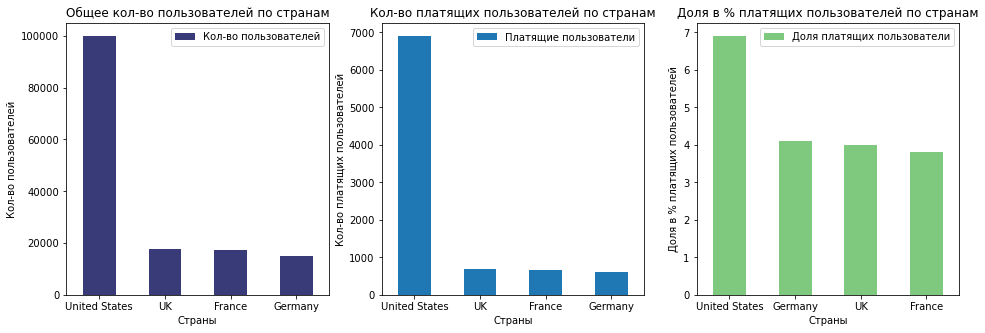

In [28]:
# визуализируем результат
plt.figure(figsize=(16, 5))

profiles_by_region.sort_values('number_of_users', ascending=False)\
                  .plot(x='region', # данные оси х
                        y='number_of_users', # данные оси y
                        kind='bar', # тип графики
                        rot=0, # угол наклона надписей
                        label='Кол-во пользователей', # название столцов
                        colormap='tab20b',
                        ax=plt.subplot(1,3,1))\
                   .set(title='Общее кол-во пользователей по странам',
                        xlabel='Страны', # наименование оси х
                        ylabel='Кол-во пользователей'); # наимепнование оси у

profiles_by_region.plot(x='region', 
                        y='solvent_users', 
                        kind='bar', 
                        rot=0, 
                        label='Платящие пользователи', 
                        ax=plt.subplot(1,3,2))\
                  .set(title='Кол-во платящих пользователей по странам', 
                        xlabel = 'Страны', 
                        ylabel='Кол-во платящих пользователей'); 

profiles_by_region.sort_values('share_of_paying_users', ascending=False)\
                  .plot(x='region',
                        y='share_of_paying_users',
                        kind='bar',
                        rot=0,
                        label='Доля платящих пользователи',
                        colormap='Accent', # цвет графики
                        ax=plt.subplot(1,3,3))\
                  .set(title='Доля в % платящих пользователей по странам',
                       xlabel='Страны',
                       ylabel='Доля в % платящих пользователей');

Пользователи приходят в приложение из 4 стран: United States, UK, France и Germany. США значительно лидируют по количеству пользователей приложения Procrastinate Pro+ (примерно 100 тыс.). Также и доля платящих пользователей выше в США - 7%. Больше всего платящих пользователей приходится на United States, 6902 пользователей. Конверсия тоже больше всего в данном регионе 6.90%. Следом по кол-ву платящих пользователей идет UK, 700 пользователей, но по проценту конверсии из общего кол-ва в платящих пользователей выше в Germany 4.11% против 3.98% в UK.

### Количество пользователей и доля платящих для каждого устройства

In [29]:
# определим общее кол-во пользователей по устройствам
amount_users_device = (
    profiles.groupby(['device'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'number_of_users'}))

# определим кол-во платящих пользователей по устройствам
solvent_users_device = (
    profiles.query('payer == True')
    .groupby(['device'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'solvent_users'}))

# сформируем общую таблицу по устройствам
profiles_by_device = (
    amount_users_device.merge(solvent_users_device, on=['device'], how='left')
    .sort_values('solvent_users', ascending=False)
    .reset_index()
)

# добавим информацию % платящих по каждому устройству
profiles_by_device['share_of_paying_users'] = (
    profiles_by_device['solvent_users'] / profiles_by_device['number_of_users'] * 100
)

# выводим результат
display(profiles_by_device)

,device,number_of_users,solvent_users,share_of_paying_users
0,iPhone,54479,3382,6.207897
1,Android,35032,2050,5.851793
2,Mac,30042,1912,6.364423
3,PC,30455,1537,5.046790


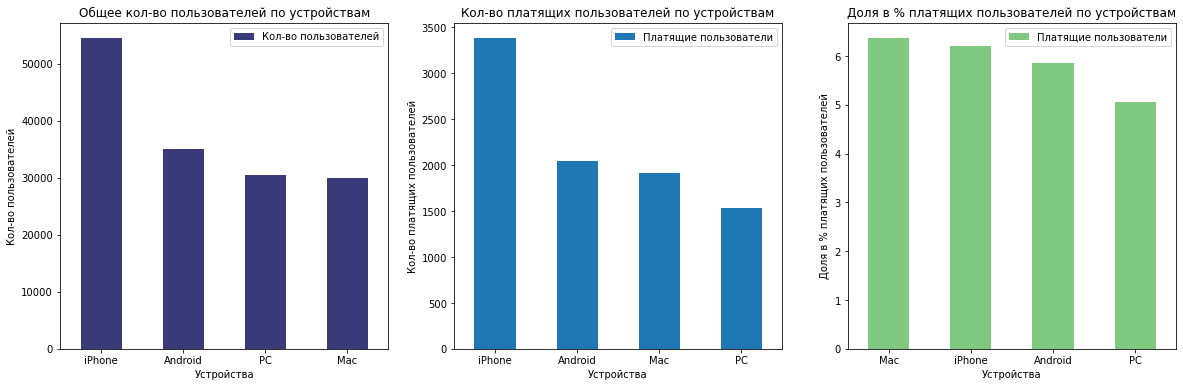

In [30]:
# визуализируем результат
plt.figure(figsize=(20, 6))

profiles_by_device.sort_values('number_of_users', ascending=False)\
                  .plot(x='device',
                        y='number_of_users',
                        kind='bar',
                        rot=0,
                        label='Кол-во пользователей',
                        colormap='tab20b',
                        ax=plt.subplot(1,3,1))\
                   .set(title='Общее кол-во пользователей по устройствам',
                        xlabel='Устройства', 
                        ylabel='Кол-во пользователей');

profiles_by_device.plot(x='device',
                        y='solvent_users',
                        kind='bar',
                        rot=0,
                        label='Платящие пользователи',
                        ax=plt.subplot(1,3,2))\
                  .set(title='Кол-во платящих пользователей по устройствам',
                       xlabel = 'Устройства',
                       ylabel='Кол-во платящих пользователей');

profiles_by_device.sort_values('share_of_paying_users', ascending=False)\
                  .plot(x='device',
                        y='share_of_paying_users',
                        kind='bar',
                        rot=0,
                        label='Платящие пользователи',
                        colormap='Accent',
                        ax=plt.subplot(1,3,3))\
                  .set(title='Доля в % платящих пользователей по устройствам',
                       xlabel='Устройства',
                       ylabel='Доля в % платящих пользователей');

Клиенты пользуются такими устройствами, как iPhone, Android, Mac и PC. Больше всего платящих клиентов используют iPhone, 3382 человек. Следующим по кол-ву платящих клиентов идет устройства на платформе Android, 2050 человек. Другая картина наблюдается по % конверсии из общего кол-ва пользователей в платящих, несмотря на третье только место по кол-ву платящих пользователей конверсия на устройствах Mac выше всех устройств 6.36%

### Доля платящих для каждого канала привлечения

In [31]:
# определим общее кол-во пользователей по каналам
amount_users_channel = (
    profiles.groupby(['channel'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'number_of_users'}))

# определим кол-во платящих пользователей по каналам
solvent_users_channel = (
    profiles.query('payer == True')
    .groupby(['channel'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'solvent_users'}))

# сформируем общую таблицу по каналам
profiles_by_channel = (
    amount_users_channel.merge(solvent_users_channel, on=['channel'], how='left')
    .sort_values('solvent_users', ascending=False)
    .reset_index()
)

# добавим информацию % платящих по каждому каналу
profiles_by_channel['share_of_paying_users'] = (
    profiles_by_channel['solvent_users'] / profiles_by_channel['number_of_users'] * 100
)

# выводим результат
display(profiles_by_channel)

,channel,number_of_users,solvent_users,share_of_paying_users
0,FaceBoom,29144,3557,12.204914
1,TipTop,19561,1878,9.600736
2,organic,56439,1160,2.055316
3,WahooNetBanner,8553,453,5.296387
4,AdNonSense,3880,440,11.340206
5,RocketSuperAds,4448,352,7.913669
6,LeapBob,8553,262,3.063253
7,OppleCreativeMedia,8605,233,2.707728
8,lambdaMediaAds,2149,225,10.469986
9,YRabbit,4312,165,3.826531


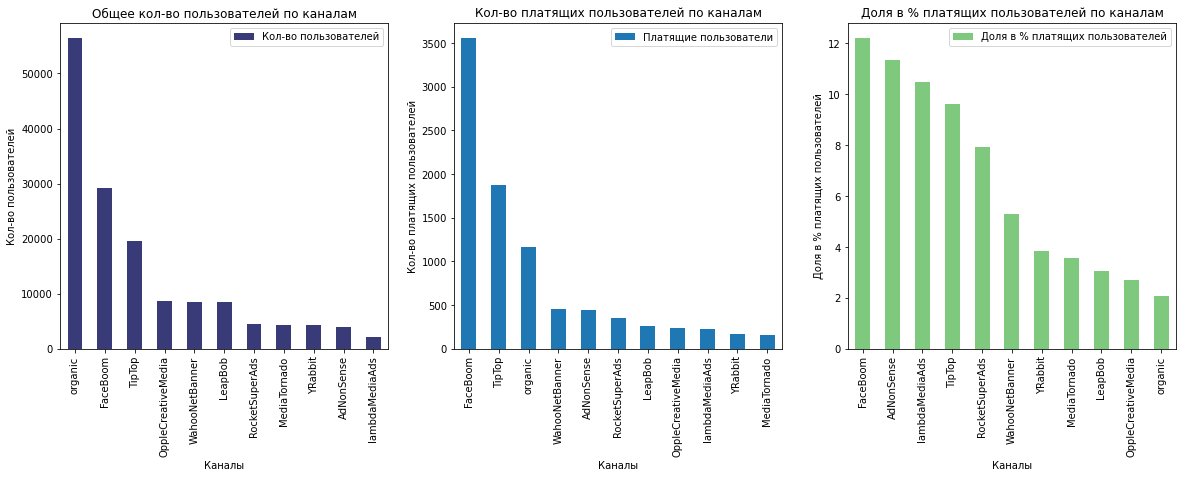

In [32]:
# визуализируем результат
plt.figure(figsize=(20, 6))
profiles_by_channel.sort_values('number_of_users', ascending=False)\
                   .plot(x='channel',
                         y='number_of_users',
                         kind='bar',
                         rot=90,
                         label='Кол-во пользователей',
                         colormap='tab20b',
                         ax=plt.subplot(1,3,1))\
                   .set(title='Общее кол-во пользователей по каналам',
                        xlabel='Каналы', 
                        ylabel='Кол-во пользователей');

profiles_by_channel.plot(x='channel',
                         y='solvent_users',
                         kind='bar',
                         rot=90,
                         label='Платящие пользователи',
                         ax=plt.subplot(1,3,2))\
                   .set(title='Кол-во платящих пользователей по каналам',
                        xlabel = 'Каналы',
                        ylabel='Кол-во платящих пользователей');

profiles_by_channel.sort_values('share_of_paying_users', ascending=False)\
                   .plot(x='channel',
                         y='share_of_paying_users',
                         kind='bar',
                         rot=90,
                         label='Доля в % платящих пользователей',
                         colormap='Accent',
                         ax=plt.subplot(1,3,3))\
                   .set(title='Доля в % платящих пользователей по каналам',
                        xlabel='Каналы', 
                        ylabel='Доля в % платящих пользователей');

Количество рекламных источников привлечения - 10 (источник Organic не входит в число так как это число пользователей, которые пришли не из источников рекламы, а сами). По кол-ву привлечения платящих клиентов, а также по конверсии лидером является канал FaceBoom. Стоит отметить канал привлечения AdNonSense, несмотря на предпоследнее место по кол-ву привлеченных клиентов, 3880 человек, по конверсии в платящих клиентов данный канал находится на втором месте 11.34 %. Скорее всего это говорит о пападании через данный канал на целевую аудиторию, но нужен дальнейший анализ. Так же стоит отметить большое общее кол-во пользователей, которые сами пришли.

## Маркетинг

### Расходы на маркетинг

Общие расходы на маркетинг

In [33]:
# расчитаем общую сумму расходов на маркетинг
marketing_total_cost = costs['costs'].sum()

print(f'Общая сумма расходов на маркетинга равна {round(marketing_total_cost)}')

Общая сумма расходов на маркетинга равна 105497


Распределение трат по рекламным источникам.

In [34]:
# расчитаем траты по рекламным источникам
channel_costs = (costs.groupby('channel')
                 .agg({'costs': 'sum'})
                 .sort_values(by='costs', ascending=False)
                 .reset_index())

display(channel_costs)

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


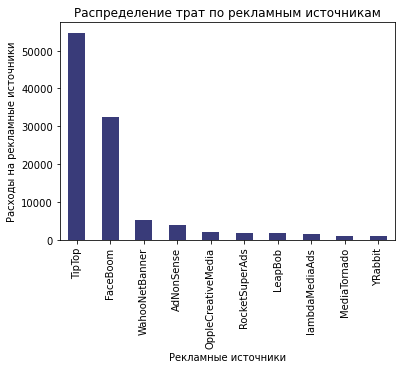

In [35]:
# визуализируем результат
channel_costs.plot(x='channel',
                   y='costs',
                   kind='bar',
                   legend=False,
                   colormap='tab20b')\
              .set(title='Распределение трат по рекламным источникам',
                   xlabel='Рекламные источники', 
                   ylabel='Расходы на рекламные источники');

Самым затратным рекламным источником является TipTop, далее идет FaceBoom. Данные источники абсолютные лидеры по затратам по сравнению с остальными источниками.

### Динамика изменения расходов во времени

In [36]:
# добавим новые столбцы
costs['dt'] = pd.to_datetime(costs['dt']) #преобразуем тип данных
costs['month'] = costs['dt'].dt.month # столбец с месяцем
costs['week'] = costs['dt'].dt.isocalendar().week # столбец с номером недели 

In [37]:
# затраты по месяцам
display(costs.groupby('month').agg({'costs': 'sum'}))

# затраты по неделям
display(costs.groupby('week').agg({'costs': 'sum'}))

,costs
month,
5,9978.570
6,15090.045
7,16447.060
8,20657.870
9,22441.340
10,20882.415


,costs
week,
18,1455.640
19,2031.820
20,1976.320
21,2297.120
22,3427.075
23,2915.740
24,2706.390
25,3421.390
26,4837.120


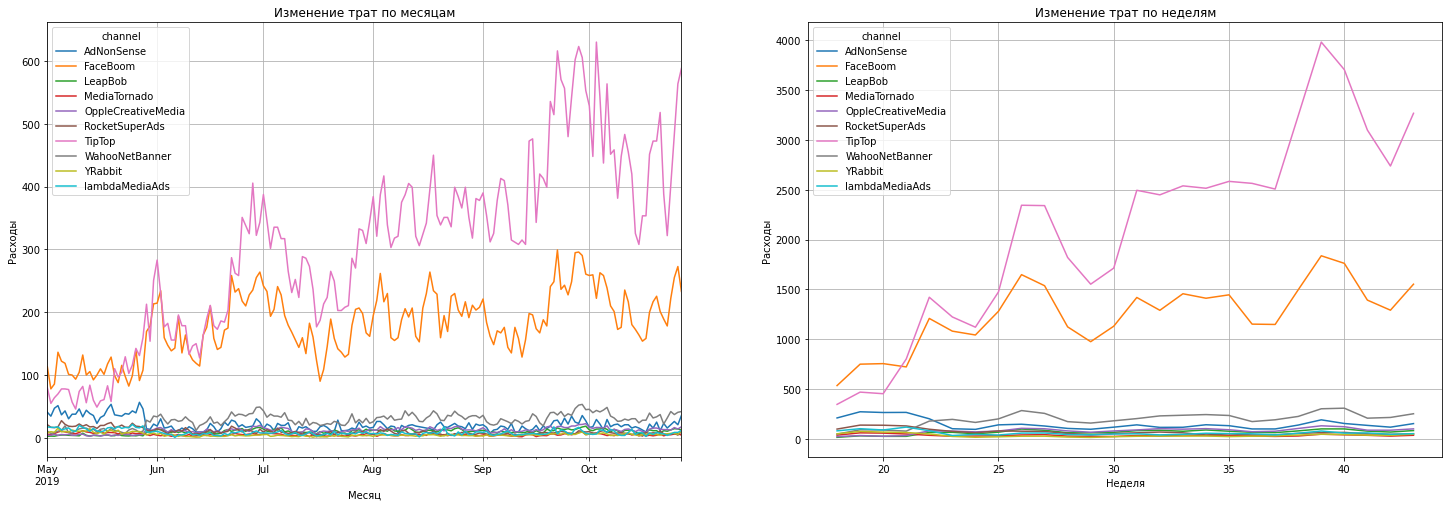

In [38]:
# визуализация изменений трат по времени ()
plt.figure(figsize=(25, 8))

costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')\
     .plot(grid=True, 
           ax=plt.subplot(1,2,1))\
     .set(title='Изменение трат по месяцам',
          xlabel='Месяц',
          ylabel='Расходы');

costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')\
     .plot(grid=True,
           ax=plt.subplot(1,2,2))\
     .set(title='Изменение трат по неделям',
          xlabel='Неделя',
          ylabel='Расходы');

По динамике изменений расходов так же выделяются абсолютные лидеры TipTop и FaceBoom, что не удивительно, так как общие расходы по этим двум источникам выше всего. По остальным каналам наблюдается относительный паритет по динамике трат по месяцам и неделям.

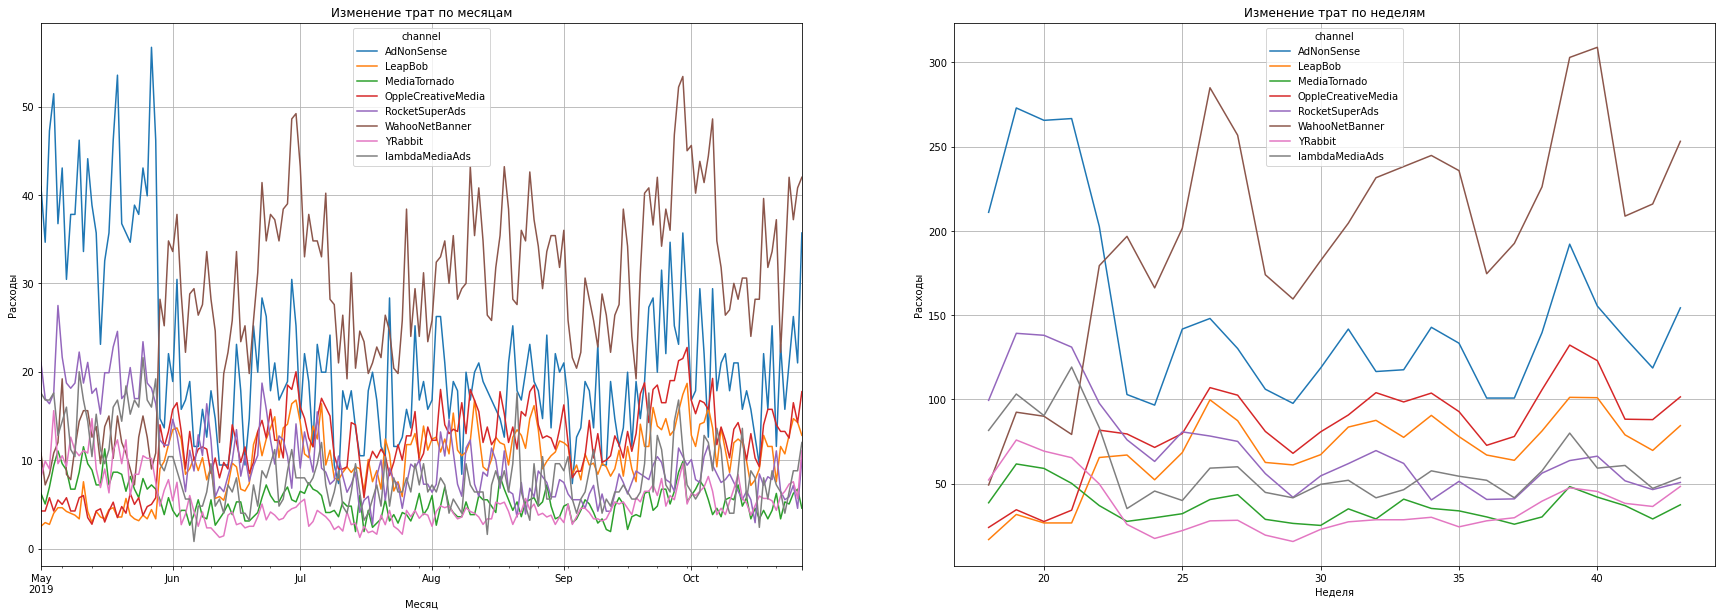

In [39]:
# визуализируем динамику без двух лидеров по тратам для детального рассмотрения по остальным каналам
plt.figure(figsize=(30, 10))

new_costs = costs.query('channel != "TipTop" & channel != "FaceBoom"')

new_costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='sum')\
         .plot(grid=True,
               ax=plt.subplot(1,2,1))\
         .set(title='Изменение трат по месяцам',
              xlabel='Месяц',
              ylabel='Расходы');

new_costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')\
         .plot(grid=True,
               ax=plt.subplot(1,2,2))\
         .set(title='Изменение трат по неделям',
              xlabel='Неделя',
              ylabel='Расходы');

Если график динамики по месяцам трудно разобрать из-за шума, то на графике по неделям можем заметить, что соблюдается относительно такая же картина по динамике трат как по общим затратам на источники рекламы. 

### Средняя стоимость привлечения одного пользователя из каждого источника (CAC)

In [40]:
# средняя стоимость привлечения одного пользователя из каждого источника
cac = profiles.groupby('channel')\
     .agg({'acquisition_cost': 'mean'})\
     .rename(columns={'acquisition_cost': 'cac'})\
     .sort_values(by='cac', ascending=False)\
     .reset_index()

display(cac)
print('Средняя стоимость привлечения пользователя в приложение:', (cac['cac'].mean()))

,channel,cac
0,TipTop,2.799003
1,FaceBoom,1.113286
2,AdNonSense,1.008054
3,lambdaMediaAds,0.724802
4,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
6,OppleCreativeMedia,0.250000
7,YRabbit,0.218975
8,MediaTornado,0.218717
9,LeapBob,0.210172


Средняя стоимость привлечения пользователя в приложение: 0.6870317251013996


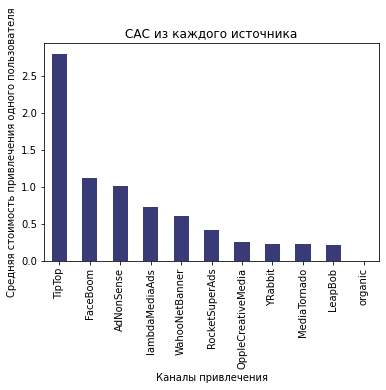

In [41]:
# визуализация САС
cac.plot(x='channel',
         y='cac',
         kind='bar',
         legend=False,
         colormap='tab20b')\
    .set(title='САС из каждого источника',
         xlabel='Каналы привлечения', 
         ylabel='Средняя стоимость привлечения одного пользователя');

В среднем затраты на привлечение одного пользователя по каналу TipTop обходится дороже всего 2,8. По сравнению с остальными каналами средние затраты на привлечение одного клиента по данному каналу (TipTop) в разы выше. 

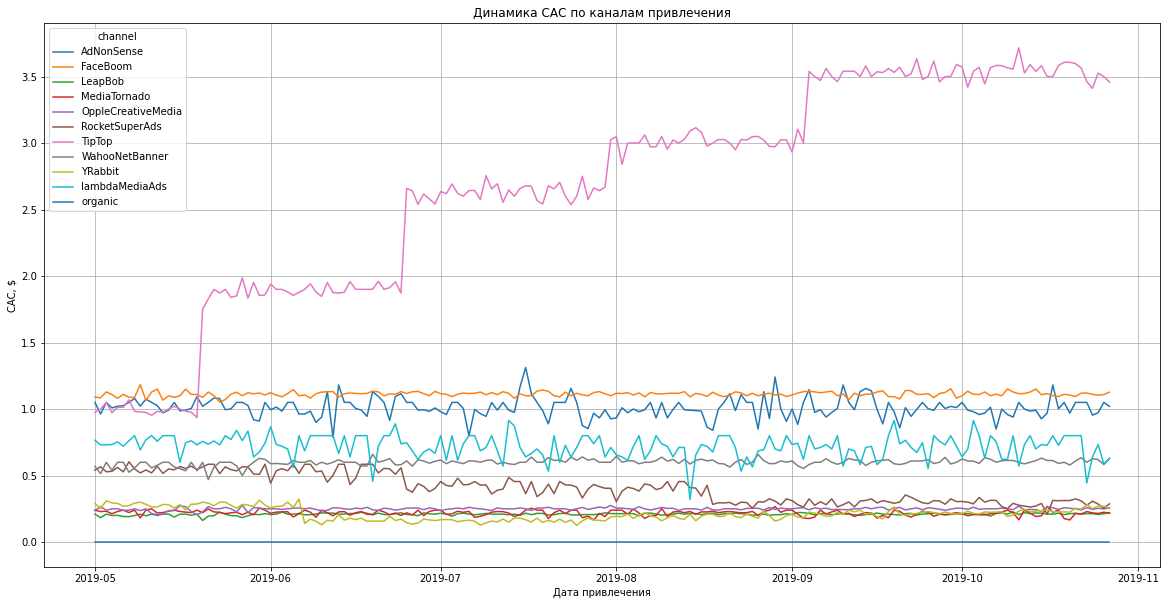

In [42]:
# строим график истории изменений CAC по каналам привлечения
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean')\
        .plot(grid=True, figsize=(20, 10))\
        .set(title='Динамика САС по каналам привлечения',
             xlabel='Дата привлечения',
             ylabel='CAC, $');

По графику динамики средних затрат на привлечение одного пользователя мы видим, что для источника TipTop затраты растут с каждым месяцем, тогда как по остальным каналам наблюдается относительная стабильность в затратах.

## Оценка окупаемости рекламы

### Окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

In [43]:
#установим момент и горизонт анализа данных
observation_date = datetime(2020, 11, 1).date() #момент анализа
horizon_days = 14 #горизонт анализа 

Считаем, что необходимо исключить канал Organic, так как мы отмечали выше кол-во данных клиентов больше всех, а затрат по себе не несут. Это может повлиять на корректность расчета метрик.

In [44]:
#исключаем органических пользователей из profiles
profiles = profiles.query('channel != "organic"')

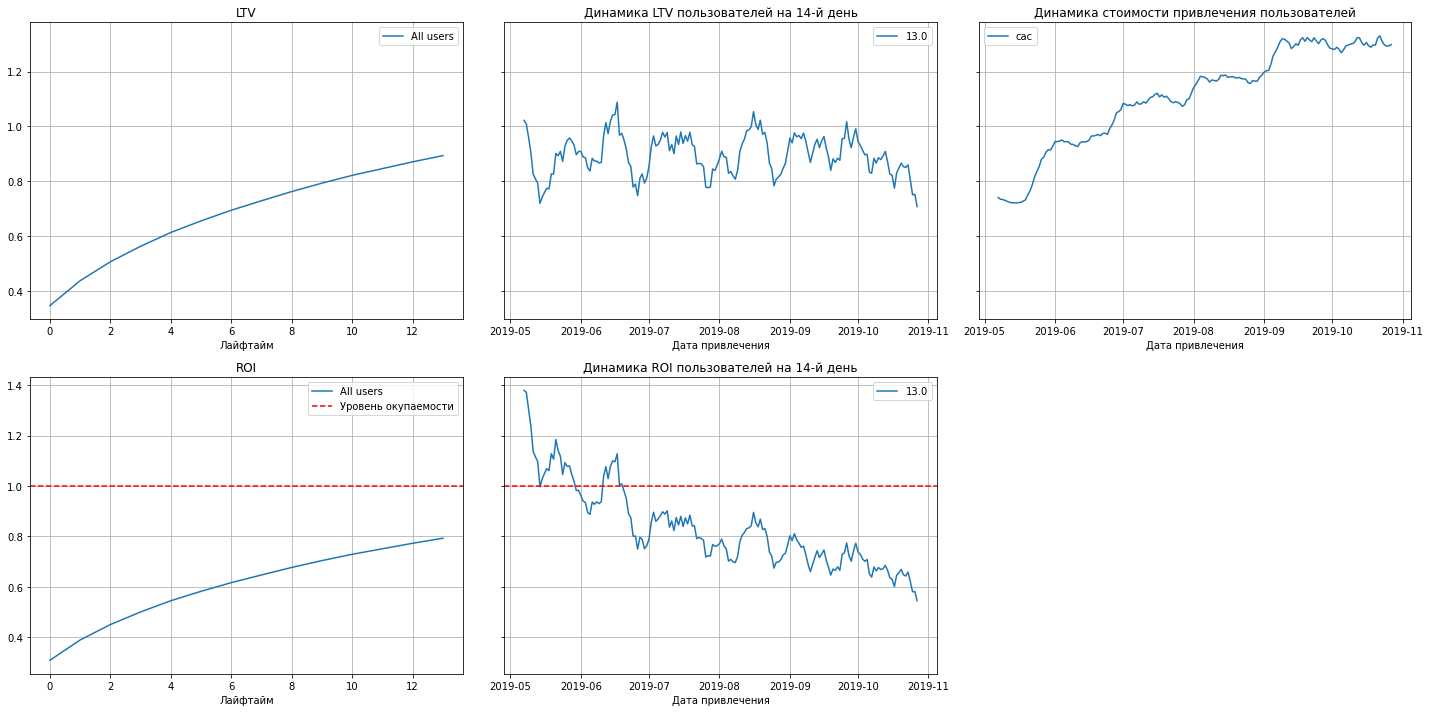

In [45]:
#считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- Реклама не окупается. ROI в конце анализируемого периода — близок к 80% окупаемости, но не выше уровня, динамика ROI клиентов падает.
- CAC не стабилен. С течением времени стоимость привлечения пользователей растет.
- LTV показатель достаточно стабильно растет. Значит, дело не в ухудшении качества пользователей.
- Скорее всего проблема в увеличении рекламного бюджета, необходим дальнейший анализ.

### Конверсия, удержание пользователей и динамика их изменений.

Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.

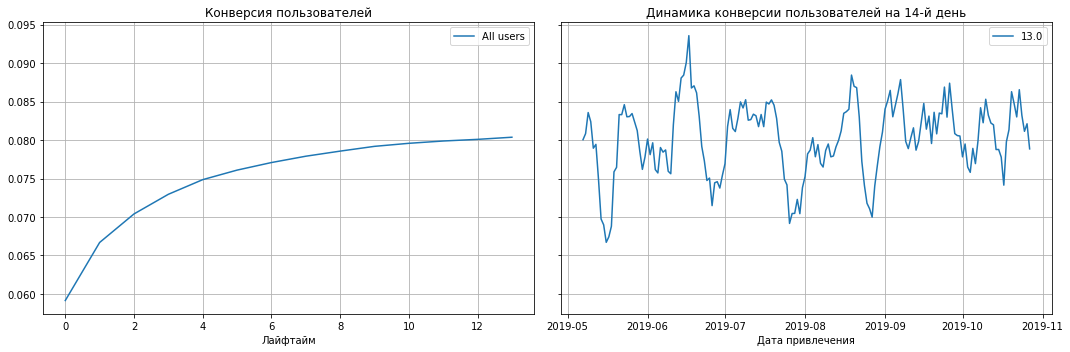

In [46]:
#считаем конверсию
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

#строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, пользователи хорошо конвертируются.

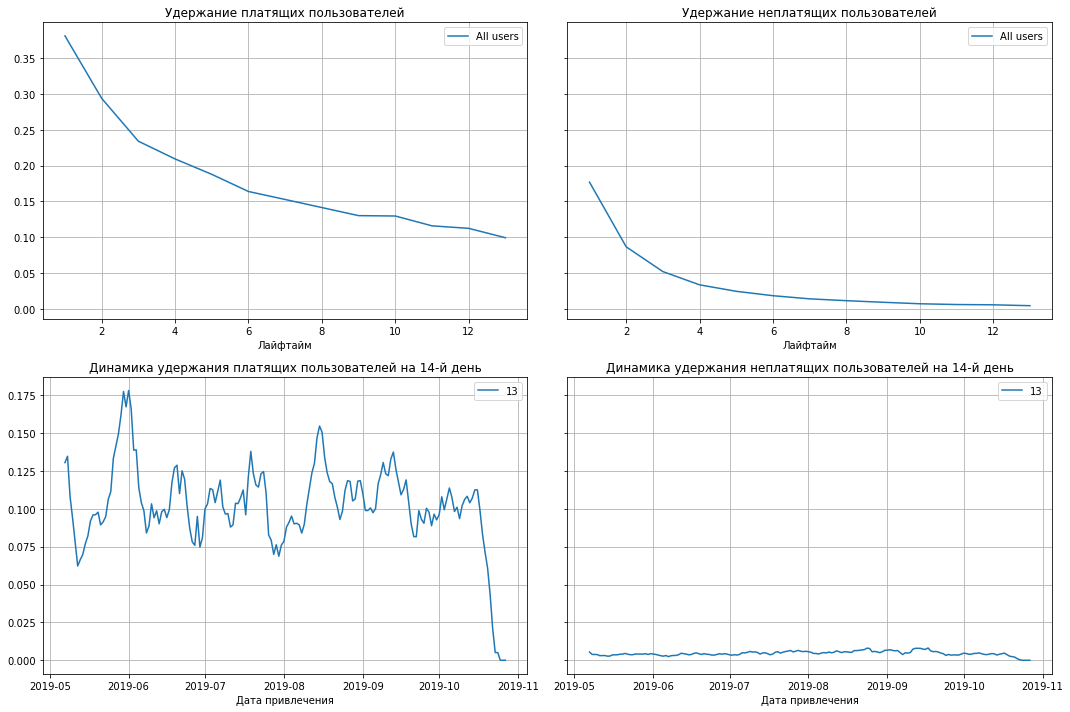

In [47]:
#считаем удержание
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

#строим графики
plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи стабильно плохо удерживаются. Для платящих пользователей удержание 14-го дня удержание резко падает. Необходим дальнейший детальный анализ.

### Окупаемость рекламы с разбивкой по устройствам

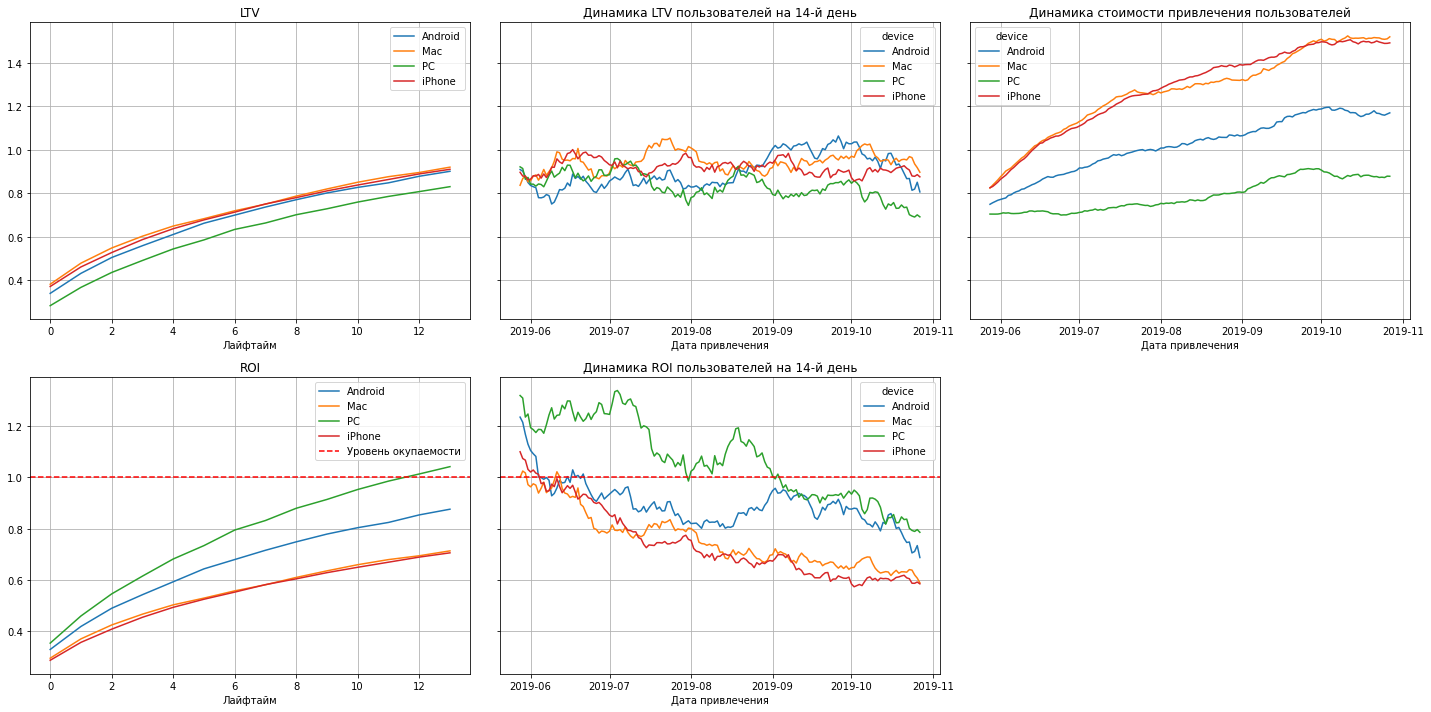

In [48]:
#считаем LTV и ROI с разбивкой по устройствам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=28) 

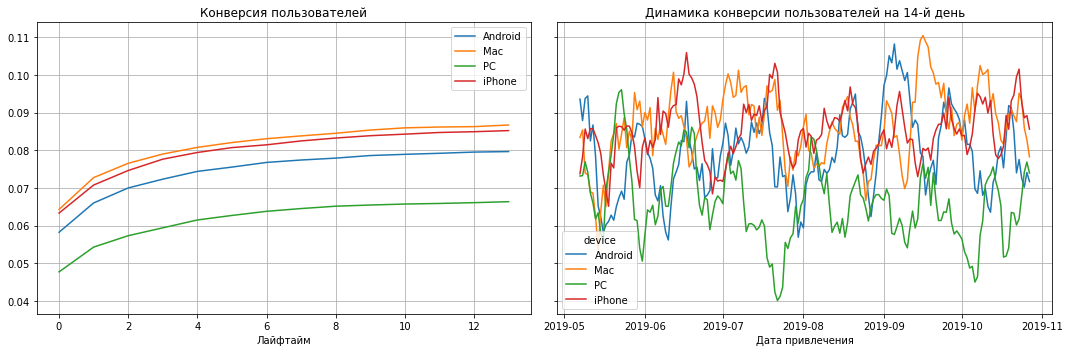

In [49]:
#считаем конверсию по устройствам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device'])

#строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

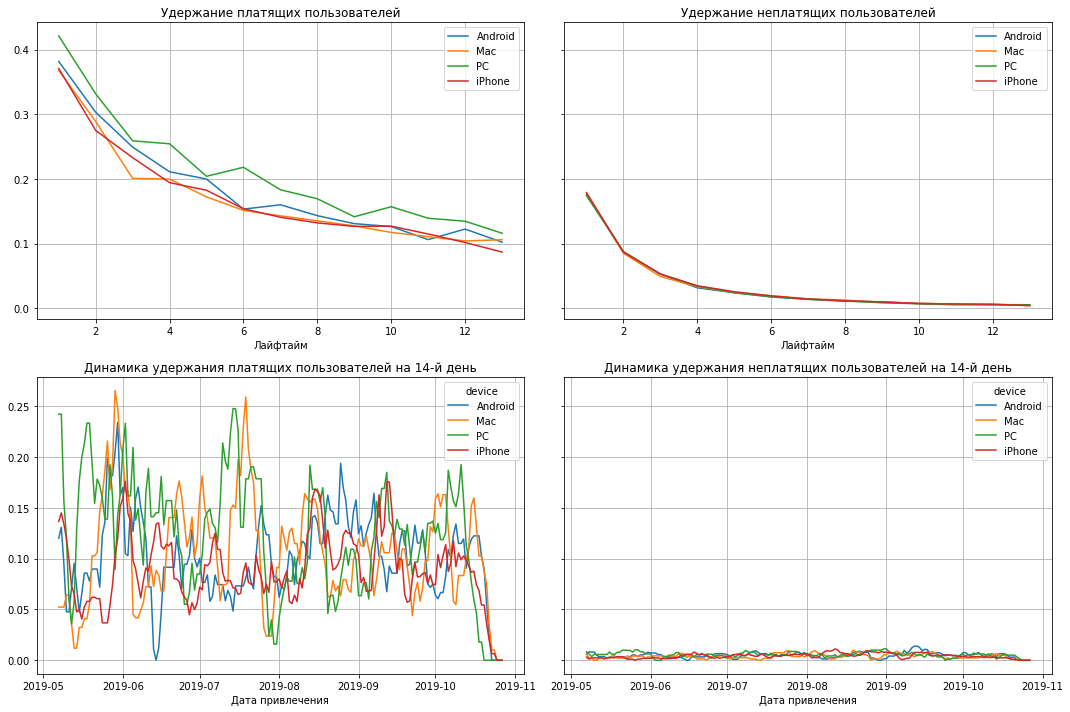

In [50]:
#считаем удержание по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device'])

#визуализируем результат
plot_retention(retention_grouped, retention_history, horizon_days)

С разбивкой по устройствам наблюдается следующая картина:
-	Реклама окупается только на устройствах PC.
-	Динамика стоимости привлечения повышается, стоимость привлечения новых клиентов на устройствах от apple выше, чем на остальных, наименьшие расходы в привлечении новых пользователей PC. Рост стоимости привлечения наблюдается по всем устройствам.
-	LTV всё так же стабильно растет.
-	Лучше всего реклама окупается на устройствах PC c 11 дня.
-	На устройствах от apple (iPhone, Mac) конвертация выше, чем по остальным устройствам, по устройству PC самый низкий показатель конверсии, но при этом по удержанию PC лучше, чем по остальным устройствам. Аномальных скачков удержания не видим, значит это не техническая проблема с приложением. Клиенты продолжают конвертироваться и удерживаться.


### Окупаемость рекламы с разбивкой по странам

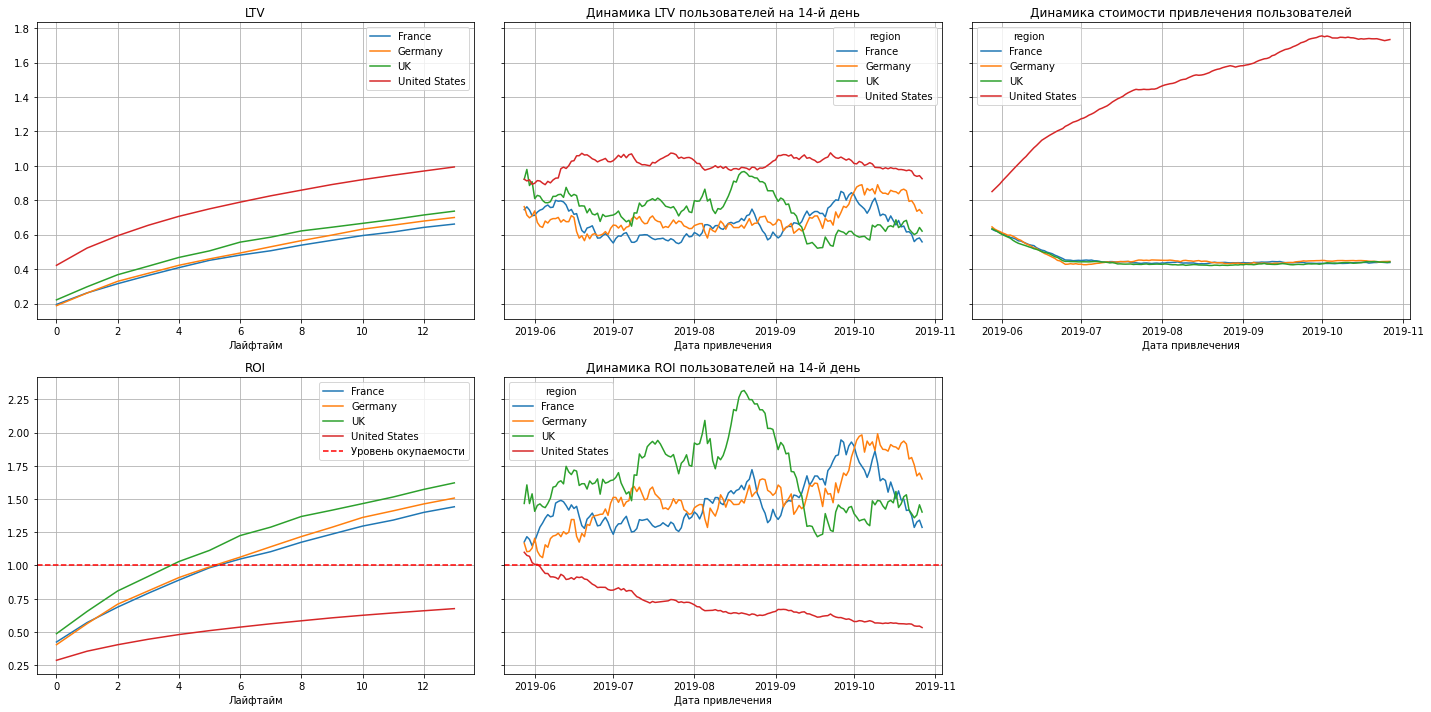

In [51]:
#считаем LTV и ROI с разбивкой по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=28) 

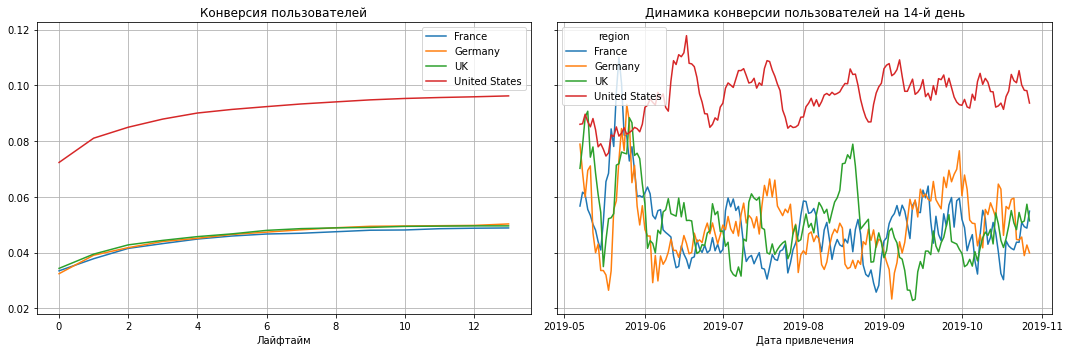

In [52]:
#считаем конверсию по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region'])

#строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

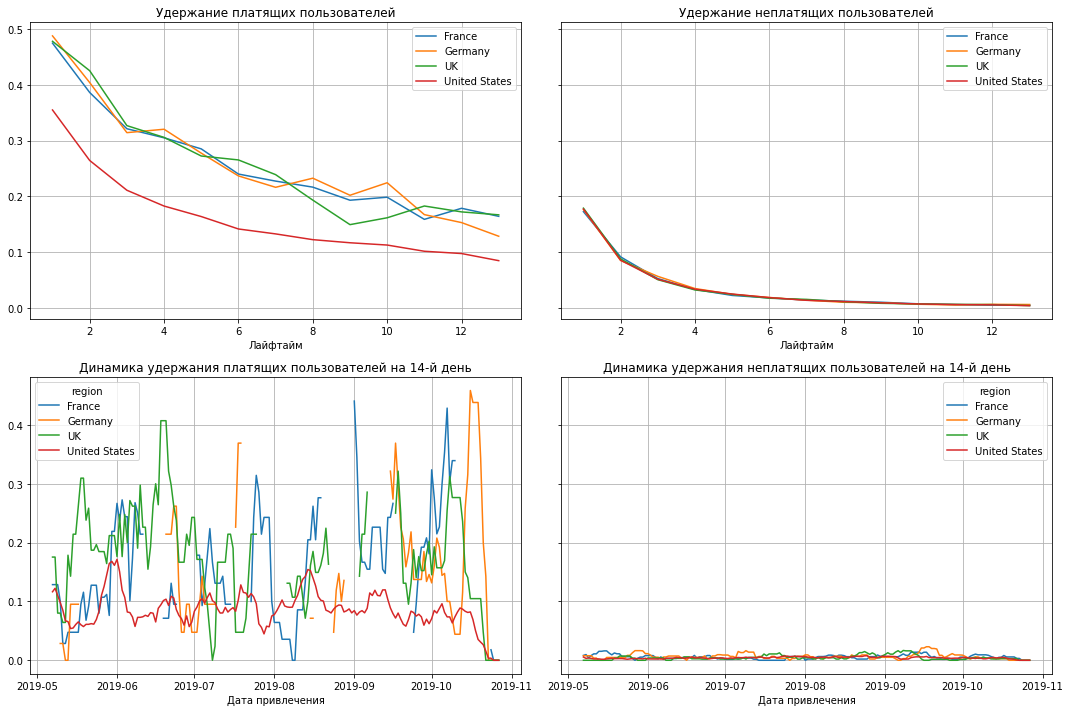

In [53]:
#считаем удержание по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region'])

#визуализируем результат
plot_retention(retention_grouped, retention_history, horizon_days)

Посмотрим на распределение источников по странам

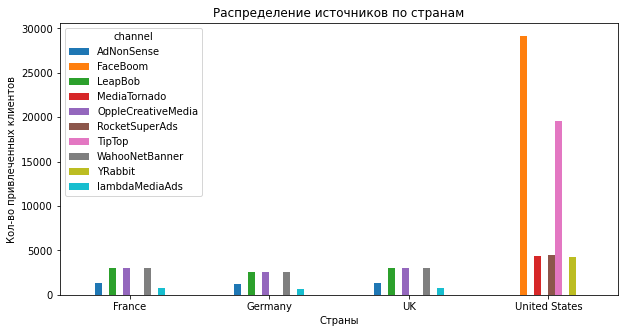

In [54]:
#строим распределение источников по странам
profiles.pivot_table(index='region', columns='channel', values='user_id', aggfunc='count')\
        .plot(kind='bar',
              rot=0,
              figsize=(10,5))\
        .set(title='Распределение источников по странам',
             xlabel='Страны',
             ylabel='Кол-во привлеченных клиентов');

С разбивкой по странам наблюдается следующая картина:
- Реклама окупается везде кроме United States.
- Динамика стоимости привлечения не стабильна так же в United States, стоимость привлечения новых клиентов существенно выше в этой стране (United States) и одинакова для всех остальных стран.
- LTV всё так же стабильно растет.
- Лучше всего окупается UK, явным аутсайдеров является United States как по ROI, так и по динамеке ROI.
- Лучше всех конвертируются пользователи из United States, но по показателю удержания самые низкие показатели.
- Самые затратные источники, как TipTip, FaceBoom приходятся только на United States. Считаем, что в этих каналах и заключается проблема окупаемости в этой стране, несмотря на самый большой показатель конверсии в United States. Проблема не в стране, было бы странно отказываться от такой огромной аудитории как в United States.

### Окупаемость рекламы с разбивкой по рекламным каналам

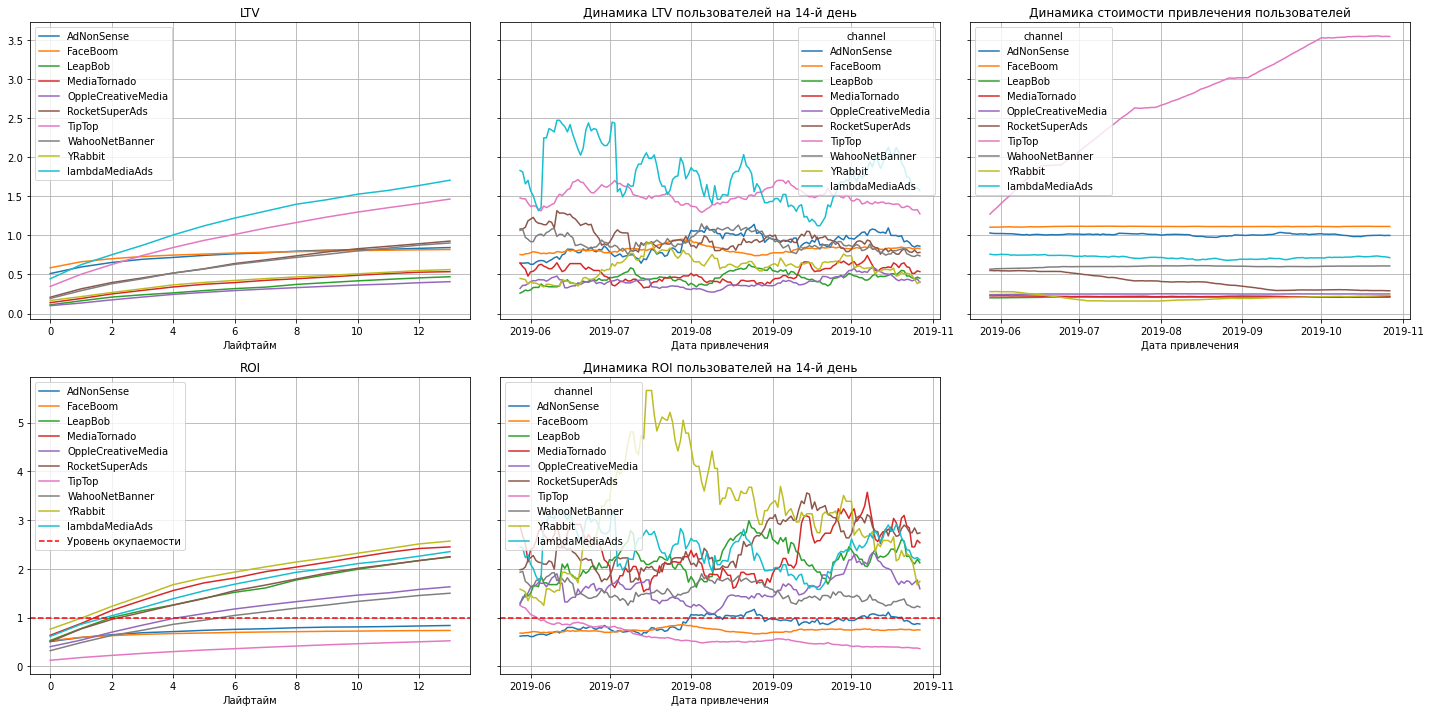

In [55]:
#считаем LTV и ROI с разбивкой по каналам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=28) 

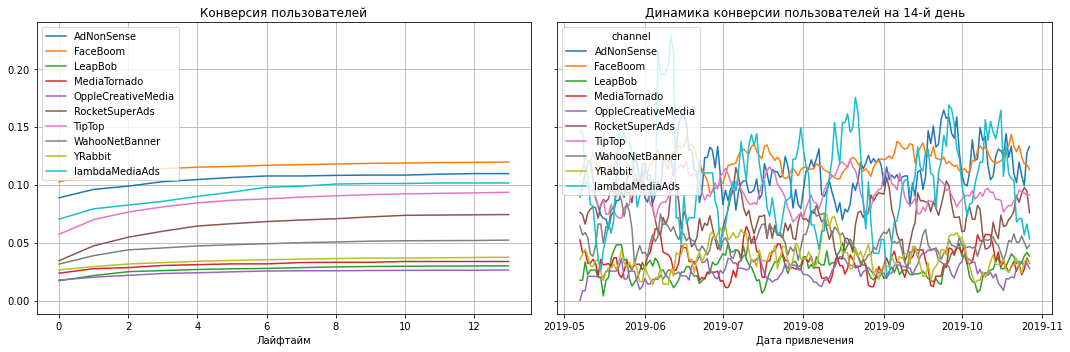

In [56]:
#считаем конверсию по каналам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel'])

#строим графики
plot_conversion(conversion_grouped, conversion_history, horizon_days) 

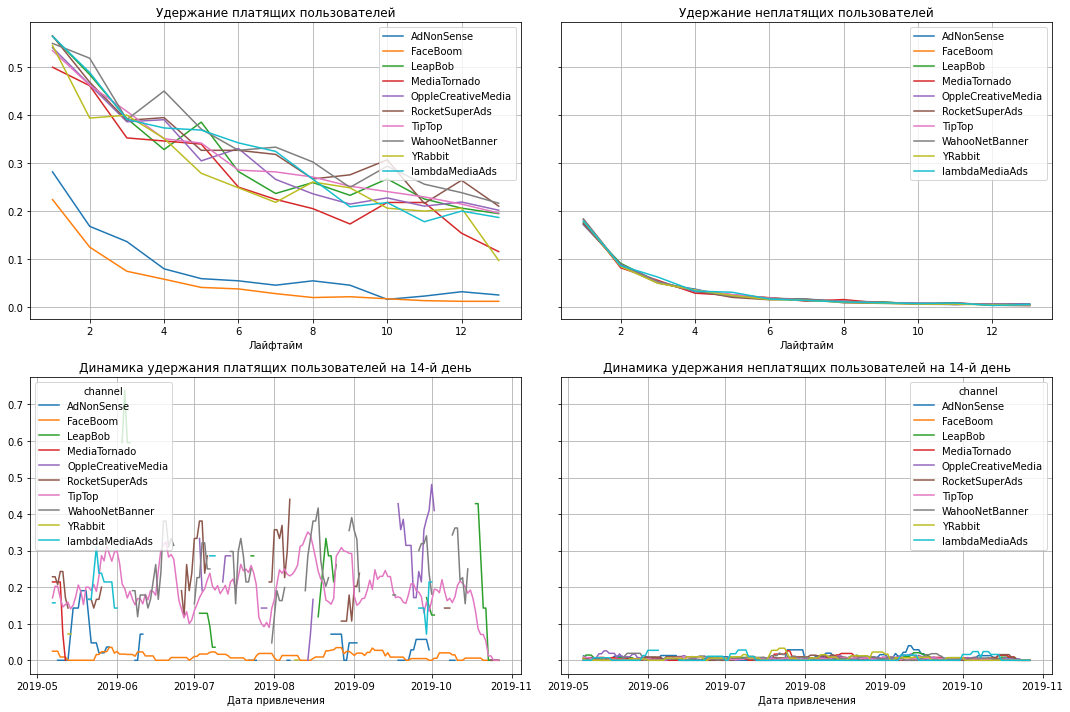

In [57]:
#считаем удержание по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel'])

#визуализируем результат
plot_retention(retention_grouped, retention_history, horizon_days)

С разбивкой по каналам наблюдается следующая картина:
- Реклама не окупается по таким источникам как: AdNonSense, FacceBoom и TipTop.
- Динамика стоимости привлечения не стабильна и растет по источнику TipTop. По каналам YRabbit, LeapBob, MediaTornado, OppleCreativeMedia самая низкая стоимость привлечения в динамике. 
- Лучше всего окупается источник рекламы YRabbit, далее идут источники MediaTornado, lambdaMediaAds и RocketSuperAds. Явным аутсайдеров является источник TipTop как по ROI, так и по динамеке ROI.
- Несмотря на то, что по конверсии источники AdNonSense и FaceBoom показывают лучший результат по удержанию являются заметными аутсайдерами. 

### Гипотеза: Источники рекламы TipTop, FaceBoom и AdNonSense оказывают негативное влияние на рекламную компанию. 

In [58]:
#проверим эту гипотезу исключив из массива данных эти каналы
profiles_custom = profiles.query('channel != "FaceBoom" & channel != "TipTop" & channel != "AdNonSense"')

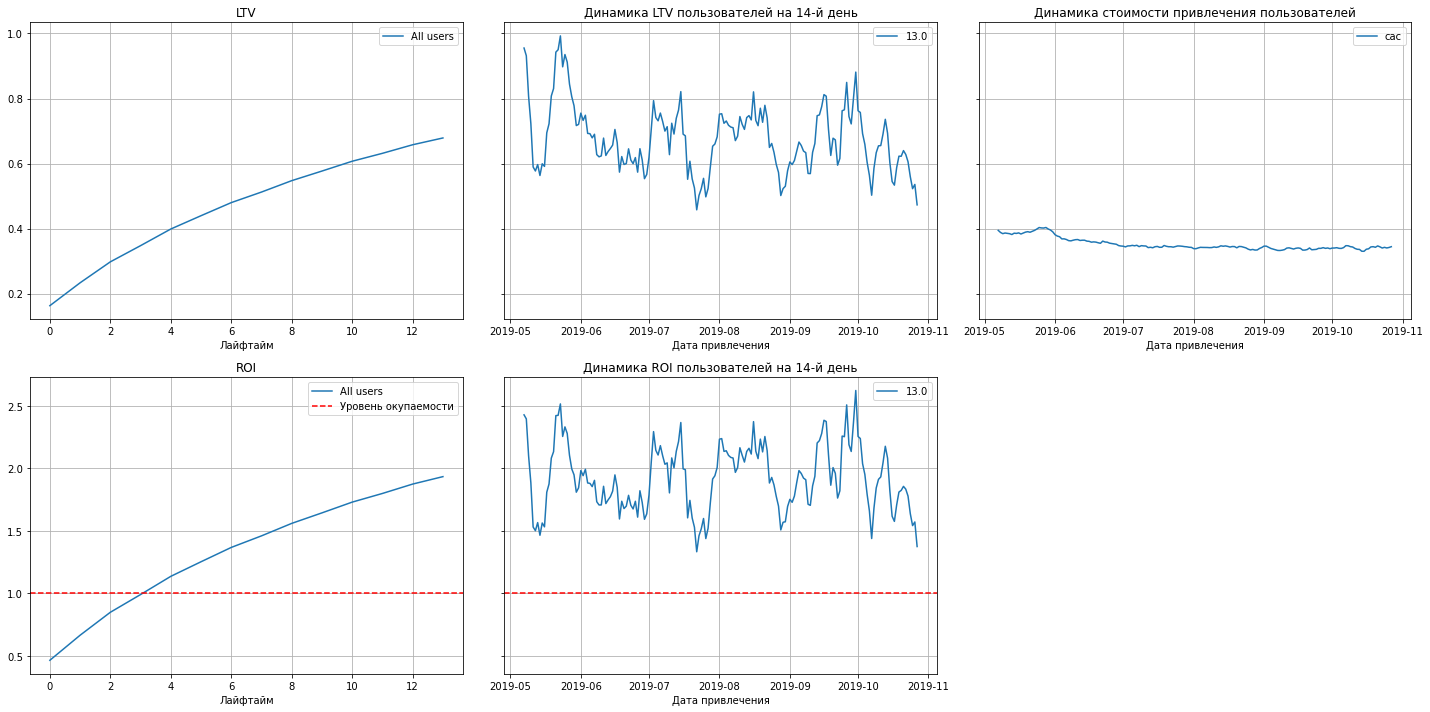

In [59]:
#считаем LTV, ROI без FaceBoom и TipTop
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_custom, orders, observation_date, horizon_days)

#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

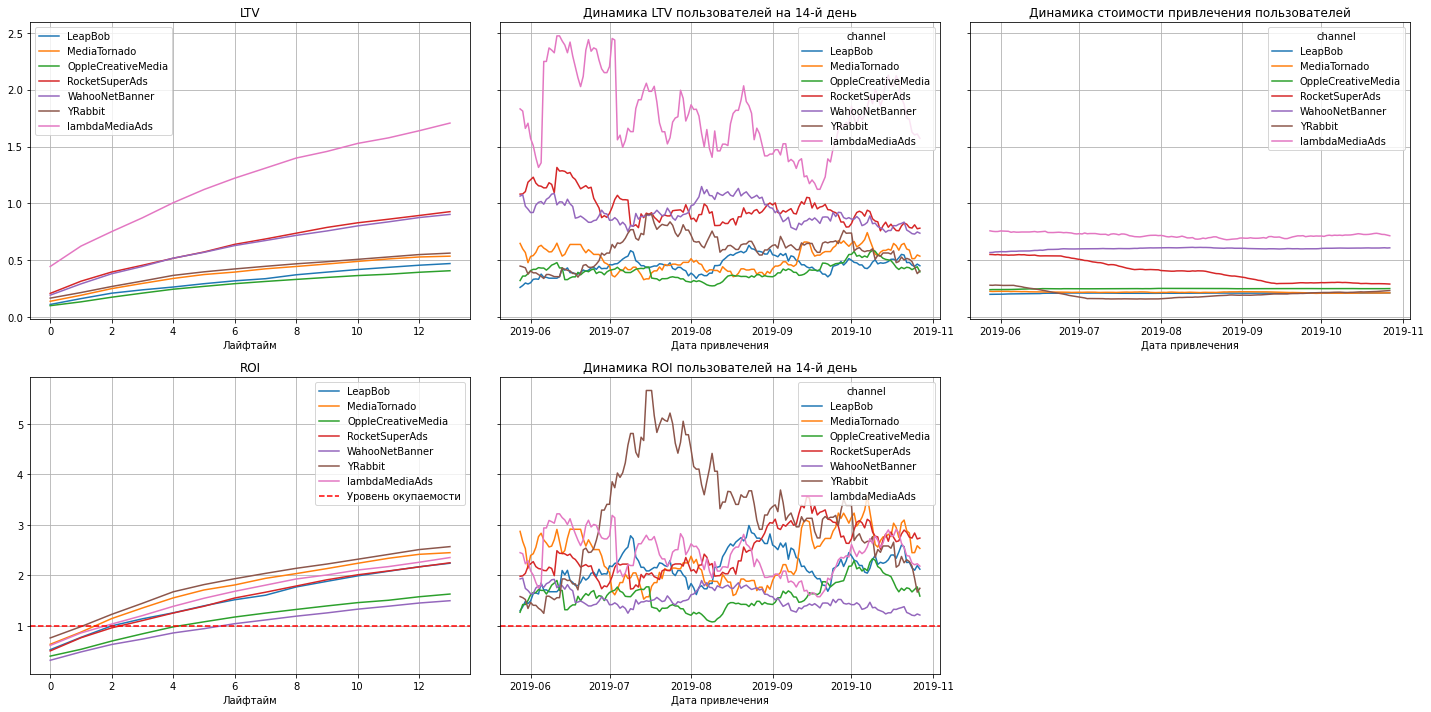

In [60]:
#считаем LTV и ROI с разбивкой по каналам без
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_custom, orders, observation_date, horizon_days, dimensions=['channel'])

#строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=28) 

По графикам без проблемных источников совершенно другая картина можно сделать такие выводы:

- Реклама окупается. ROI в конце анализируемого периода —  выше уровня окупаемости на 75%, динамика ROI клиентов стабильно выше порога окупаемости. Все оставшиеся источники окупаются.
- CAC стабилен. С течением времени стоимость привлечения пользователей не растет.
- LTV показатель достаточно стабильно растет.

Наша гипотеза подтверждается, отделу маркетинга стоит обратить внимание на эти проблемные источники рекламы.

## Выводы

В нашем распоряжении оказались данные по пользователям приложения Procrastinate Pro+. Мы выполнили предобработку данных, выяснили, что:
- пропуски отсутствуют 
- явные дубликаты отсутствуют
- аномальных значений не выявили
- отредактировали названия столбцов
- заменили тип данных на необходимые для корректной работы.

Проведя исследовательский анализ данных, отметили:
- Пользователи приходят в приложение из 4 стран: United States, UK, France и Germany. США значительно лидируют по количеству пользователей приложения Procrastinate Pro+ (примерно 100 тыс.). Также и доля платящих пользователей выше в США - 7%. Больше всего платящих пользователей приходится на United States, 6902 пользователей. Конверсия тоже больше всего в данном регионе 6.90%. Следом по кол-ву платящих пользователей идет UK, 700 пользователей, но по проценту конверсии из общего кол-ва в платящих пользователей выше в Germany 4.11% против 3.98% в UK.
- Клиенты пользуются такими устройствами, как iPhone, Android, Mac и PC. Больше всего платящих клиентов используют iPhone, 3382 человек. Следующим по кол-ву платящих клиентов идет устройства на платформе Android, 2050 человек. Другая картина наблюдается по % конверсии из общего кол-ва пользователей в платящих, несмотря на третье только место по кол-ву платящих пользователей конверсия на устройствах Mac выше всех устройств 6.36%
- Количество рекламных источников привлечения - 10 (источник Organic не входит в число так как это число пользователей, которые пришли не из источников рекламы, а сами). По кол-ву привлечения платящих клиентов, а также по конверсии лидером является канал FaceBoom. Так же стоит отметить большое общее кол-во пользователей, которые сами пришли.
- По динамике изменений расходов выделяются абсолютные лидеры TipTop и FaceBoom, что не удивительно, так как общие расходы по этим двум источникам выше всего. По остальным каналам наблюдается относительный паритет по динамике трат по месяцам и неделям. В среднем затраты на привлечение одного пользователя по каналу TipTop обходится дороже всего 2,8. По сравнению с остальными каналами средние затраты на привлечение одного клиента по данному каналу (TipTop) в разы выше.

**Оценка окупаемости рекламы:**
- Реклама не окупается. ROI в конце анализируемого периода — близок к 80% окупаемости, но не выше уровня, динамика ROI клиентов падает. 
- CAC не стабилен. С течением времени стоимость привлечения пользователей растет. 
- LTV показатель достаточно стабильно растет.

**Оценка окупаемости рекламы c разбивкой по устройствам наблюдается следующая картина:**
- Реклама окупается только на устройствах PC.
- Динамика стоимости привлечения повышается, стоимость привлечения новых клиентов на устройствах от apple выше, чем на остальных, наименьшие расходы в привлечении новых пользователей PC. Рост стоимости привлечения наблюдается по всем устройствам.
- LTV всё так же стабильно растет.
- На устройствах от apple (iPhone, Mac) конвертация выше, чем по остальным устройствам, по устройству PC самый низкий показатель конверсии, но при этом по удержанию PC лучше чем по остальным устройствам. Аномальных скачков удержания не видим, значит это не техническая проблема с приложением. Клиенты продолжают конвертироваться и удерживаться.


**Оценка окупаемости рекламы c разбивкой по странам наблюдается следующая картина:**
- Реклама окупается везде кроме United States.
- Динамика стоимости привлечения не стабильна так же в United States, стоимость привлечения новых клиентов существенно выше в этой стране (United States) и одинакова для всех остальных стран.
- LTV всё так же стабильно растет.
- Лучше всего окупается UK, явным аутсайдеров является United States как по ROI, так и по динамеке ROI.
- Лучше всех конвертируются пользователи из United States, но по показателю удержания самые низкие показатели.
- Самые затратные источники, как TipTip, FaceBoom приходятся только на United States. Считаем, что в этих каналах и заключается проблема окупаемости в этой стране, несмотря на самый большой показатель конверсии в United States. Проблема не в стране, было бы странно отказываться от такой огромной аудитории как в United States.

**Оценка окупаемости рекламы c разбивкой по каналам наблюдается следующая картина:**
- Реклама не окупается по таким источникам как: AdNonSense, FacceBoom и TipTop.
- Динамика стоимости привлечения не стабильна и растет по источнику TipTop. По каналам YRabbit, LeapBob, MediaTornado, OppleCreativeMedia самая низкая стоимость привлечения в динамике.
- Лучше всего окупается источник рекламы YRabbit, далее идут источники MediaTornado, lambdaMediaAds и RocketSuperAds. Явным аутсайдеров является источник TipTop как по ROI, так и по динамике ROI.
- Несмотря на то, что по конверсии источники AdNonSense и FaceBoom показывают лучший результат по удержанию являются заметными аутсайдерами.

**Для формирования рекомендаций для отдела маркетинга выдвинули следующую гипотезу: 
Источники рекламы TipTop, FaceBoom и AdNonSense оказывают негативное влияние на рекламную компанию. Гипотеза входе анализа была подтверждена расчетами и сформированы следующие выводы про рекламную компанию без этих каналов:**
- Реклама окупается. ROI в конце анализируемого периода — выше уровня окупаемости на 75%, динамика ROI клиентов стабильно выше порога окупаемости. Все оставшиеся источники окупаются.
- CAC стабилен. С течением времени стоимость привлечения пользователей не растет.
- LTV показатель достаточно стабильно растет.
- По кол-ву платящих пользователей, по конверсии и стоимости привлечения новых клиентов RocketSuperAds можно выделить как самый перспективный источник рекламы

**Рекламному отделу развлекательного приложения Procrastinate Pro+ рекомендуется сократить финансирование на маркетинг там, где стоимость привлечения слишком большая - это расходы на пользователей из источников: TipTop, FaceBoom и AdNonSense.**
